#**Importación y tratatamiento inicial de los datos de pengüins**

In [ ]:
from google.colab import files
!pip install -q kaggle
uploaded = files.upload()

Saving kaggle.json to kaggle.json


Se carga el dataset de especies de pingüinos de kaggle.

In [ ]:
!mv kaggle.json /root/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download parulpandey/palmer-archipelago-antarctica-penguin-data
! unzip palmer-archipelago-antarctica-penguin-data.zip

  0% 0.00/11.3k [00:00<?, ?B/s]
100% 11.3k/11.3k [00:00<00:00, 4.30MB/s]
Archive:  palmer-archipelago-antarctica-penguin-data.zip
  inflating: penguins_lter.csv       
  inflating: penguins_size.csv       


Se crea el dataframe de pengüins.

In [ ]:
import pandas as pd
penguins = pd.read_csv('penguins_size.csv')
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [ ]:
from sklearn.model_selection import train_test_split

X = penguins.drop("species", axis=1)
y = penguins.species.astype("category")

X_train, X_test, y_train_tree, y_test_tree = train_test_split(
                        X, y, test_size=.2, random_state=42)
y_train = y_train_tree.cat.codes
y_test  = y_test_tree.cat.codes

##**Substitución de los valores nulos por la mediana**

In [ ]:
X_train_num = X_train.drop(["island", "sex"], axis=1)

from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median") 

X_train_num_array = num_imputer.fit_transform(X_train_num)
X_train_num = pd.DataFrame(X_train_num_array, columns=X_train_num.columns, index=X_train_num.index) 
X_train_num.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
66,35.5,16.2,195.0,3350.0
229,46.8,15.4,215.0,5150.0
7,39.2,19.6,195.0,4675.0
140,40.2,17.1,193.0,3400.0
323,49.1,15.0,228.0,5500.0


In [ ]:
X_test_num = X_test.drop(["island", "sex"], axis=1)
X_test_num_array = num_imputer.fit_transform(X_test_num)
X_test_num = pd.DataFrame(X_test_num_array, columns=X_test_num.columns, index=X_test_num.index)

##**Tratamiento de los valores categóricos**

Ahora vamos a realizar algunas tareas de manejo de atributos categóricos, en concreto aplicar una transformación de los atributos *island* y *sex* mediante **OneHotEncoder**.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
preprocessor = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)])
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)
#Devuelve un array(sin el nombre de las columnas), una matriz de 1 y 0, que hay que convertir en df y darle los nombres de las columnas
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=preprocessor.named_transformers_['onehot'].get_feature_names_out())
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=preprocessor.named_transformers_['onehot'].get_feature_names_out())

In [ ]:
X_train_num.reset_index(drop=True, inplace=True) # Resetear índices de las instancias para asegurar coherencia al fusionar los datos
X_test_num.reset_index(drop=True, inplace=True)

X_train_encoded_df.reset_index(drop=True, inplace=True) # Resetear índices de las instancias para asegurar coherencia al fusionar los datos
X_test_encoded_df.reset_index(drop=True, inplace=True)

X_train_prepared = pd.concat([X_train_num, X_train_encoded_df], axis=1) # Se fusionan todos los atributos necesarios
X_test_prepared = pd.concat([X_test_num, X_test_encoded_df], axis=1)

#**Sprint 1**

Para el entrenamiento de los modelos se parte de la versión de datos pre-procesada que se ha obtenido en el apartado anterior, es decir, aquella en la que los valores nulos para alguna característica se sustituyen por la mediana de su distribución, y en la que las variables categóricas se han convertido en numéricas binarias por medio de una técnica de “One Hot Encoding". Por tanto, se hace uso de todas las características del dataset en el entrenamiento el modelo, lo que se va a ver reflejado en el gran resultado de los mismos.

##**Entrenar y evaluar un modelo de regresión softmax**

In [ ]:
from sklearn.linear_model import LogisticRegression

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
softmax_reg.fit(X_train_prepared, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
print('La precisión del modelo en el conjunto de entrenamiento es:',softmax_reg.score(X_train_prepared, y_train))
y_pred = softmax_reg.predict(X_train_prepared)
train_conf_matrix = confusion_matrix(y_train, y_pred)
print('La matriz de confusión en el conjunto de etrenamiento es:\n',train_conf_matrix)
print('f1 score en el conjunto de entrenamiento:',f1_score(y_train, y_pred, average='weighted'))

La precisión del modelo en el conjunto de entrenamiento es: 1.0
La matriz de confusión en el conjunto de etrenamiento es:
 [[120   0   0]
 [  0  52   0]
 [  0   0 103]]
f1 score en el conjunto de entrenamiento: 1.0


In [ ]:
print('La precisión del modelo en el conjunto de test es:',softmax_reg.score(X_test_prepared, y_test))
y_pred = softmax_reg.predict(X_test_prepared)
test_conf_matrix = confusion_matrix(y_test, y_pred)
print('La matriz de confusión en el conjunto de test es:\n',test_conf_matrix)
print('f1 score en el conjunto de test:',f1_score(y_test, y_pred, average='weighted'))

La precisión del modelo en el conjunto de test es: 0.9855072463768116
La matriz de confusión en el conjunto de test es:
 [[31  1  0]
 [ 0 16  0]
 [ 0  0 21]]
f1 score en el conjunto de test: 0.9856118116987682


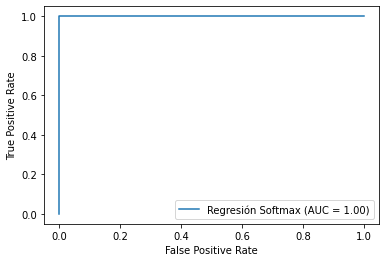

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_pred, y_test, pos_label=2)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
estimator_name='Regresión Softmax')
display.plot()
plt.show()

Es decir, se clasifican correctamente todas las instancias de test. Además, se emplea como métrica la curva ROC y el área bajo la curva, obteniendo obviamente una curva ideal y un área bajo la curva de 1.

##**Entrenar y evaluar un modelo de máquinas de vectores de soporte (SVM)**

Se entrenará un modelo de "support vector machine", y será un "linear support vector clasiffier", seleccionando como hiperparámetros los seleccionados como mejores por la función "GridSearchCV". 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC 
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'C': [0.1, 0.5, 1, 2, 5], 'loss': ['hinge','squared_hinge']}, 
              {'C': [0.1, 0.5, 1, 2, 5], 'loss': ['hinge','squared_hinge'], 'fit_intercept': [False]}, 
]

svm_grid = LinearSVC(max_iter=10000) 

grid_search = GridSearchCV(svm_grid, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                          )

grid_search.fit(X_train_prepared, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=10000),
             param_grid=[{'C': [0.1, 0.5, 1, 2, 5],
                          'loss': ['hinge', 'squared_hinge']},
                         {'C': [0.1, 0.5, 1, 2, 5], 'fit_intercept': [False],
                          'loss': ['hinge', 'squared_hinge']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_estimator_

LinearSVC(C=1, max_iter=10000)

In [ ]:
import numpy as np

cvresults = grid_search.cv_results_
for mean_score, params in zip(cvresults["mean_test_score"], cvresults["params"]):
  print(np.sqrt(-mean_score), params)

0.6578200914591107 {'C': 0.1, 'loss': 'hinge'}
0.7083912632282966 {'C': 0.1, 'loss': 'squared_hinge'}
0.7579877667518484 {'C': 0.5, 'loss': 'hinge'}
0.5222329678670935 {'C': 0.5, 'loss': 'squared_hinge'}
0.39542842128966443 {'C': 1, 'loss': 'hinge'}
0.37658754867650873 {'C': 1, 'loss': 'squared_hinge'}
0.7507571935295484 {'C': 2, 'loss': 'hinge'}
0.6438520439863917 {'C': 2, 'loss': 'squared_hinge'}
0.620849857416868 {'C': 5, 'loss': 'hinge'}
0.5752469825293227 {'C': 5, 'loss': 'squared_hinge'}
0.5257029925382167 {'C': 0.1, 'fit_intercept': False, 'loss': 'hinge'}
0.6266795614405122 {'C': 0.1, 'fit_intercept': False, 'loss': 'squared_hinge'}
0.578399044384977 {'C': 0.5, 'fit_intercept': False, 'loss': 'hinge'}
0.4177863742936748 {'C': 0.5, 'fit_intercept': False, 'loss': 'squared_hinge'}
0.6 {'C': 1, 'fit_intercept': False, 'loss': 'hinge'}
0.4972652484064488 {'C': 1, 'fit_intercept': False, 'loss': 'squared_hinge'}
0.6494753127087909 {'C': 2, 'fit_intercept': False, 'loss': 'hinge'}
0.

Es decir, se empleará un clasificador lineal, de parámetro regularizador C=1, y con una función de coste "squared hinge". 

In [ ]:
svm_classifier_best = Pipeline([
                           ("scaler", StandardScaler()),
                           ("linear_svc", LinearSVC(C=1, loss="squared_hinge", fit_intercept=False, max_iter=10000)),
])

svm_classifier_best.fit(X_train_prepared, y_train)

y_pred = svm_classifier_best.predict(X_test_prepared)
print ("La precisión en el conjunto de test es:",accuracy_score(y_test, y_pred))

La precisión en el conjunto de test es: 1.0


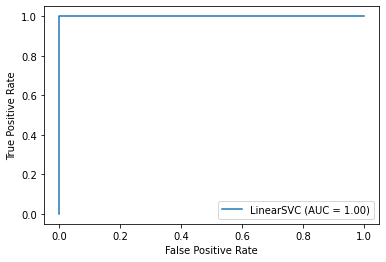

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_pred, y_test, pos_label=2)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
estimator_name='LinearSVC')
display.plot()
plt.show()

Los resultados, como cabe esperar son igual de buenos que en el caso anterior, "perfectos".

Ambos modelos clasifican correctamente todas las instancias de entrenamiento y test. Esto se debe al uso de todas las características de las que se dispone, y a que se trata de un ejemplo de "fácil" clasificación. Es más sencillo el modelo de regresión logística, con lo que lo lógico sería quedarse con este. Si nos enfrentasemos a conjuntos más complejos, y fundamentalmente aquellos en los que las clases no son linealmente separables, se debería recurrir a SVC con kernels.

##**Entrenar y evaluar un modelo de regresión logística**

Se puede realizar una clasificación binaria cogiendo cada una de las clases y clasificándola frente a las otras dos, mediante una regresión logística. Para ello, se codifican como 1 los targets de la clase que se quiere clasificar y como 0 los de las otras dos

In [ ]:
y_train_new = (y_train==0)
y_train_new = y_train_new.astype(int)
print(y_train_new)
y_test_new = (y_test==0)
y_test_new = y_test_new.astype(int)

66     1
229    0
7      1
140    1
323    0
      ..
188    0
71     1
106    1
270    0
102    1
Length: 275, dtype: int64


In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_prepared, y_train_new)

LogisticRegression(max_iter=1000)

In [ ]:
score_entrenamiento = log_reg.score(X_train_prepared,y_train_new)
score = log_reg.score(X_test_prepared,y_test_new)
y_pred = log_reg.predict(X_train_prepared)
y_pred_test = log_reg.predict(X_test_prepared)
print("La precisión en el conjunto de entrenamiento es:", score_entrenamiento)
print("La precisión en el conjunto de test es:", score)
print("f1 score en el conjunto de entrenamiento es:", f1_score(y_train_new,y_pred))
print("f1 score en el conjunto de test es:", f1_score(y_test_new,y_pred_test))

La precisión en el conjunto de entrenamiento es: 0.9963636363636363
La precisión en el conjunto de test es: 0.9855072463768116
f1 score en el conjunto de entrenamiento es: 0.99581589958159
f1 score en el conjunto de test es: 0.9841269841269841


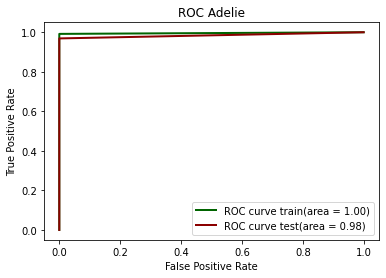

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_test = log_reg.predict(X_test_prepared)
y_pred_train = log_reg.predict(X_train_prepared)

fpr_test, tpr_test, _ = roc_curve(y_test_new,y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, _ = roc_curve(y_train_new,y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

plt.plot(fpr_train,tpr_train,color="darkgreen",lw=2,label="ROC curve train(area = %0.2f)" % roc_auc_train,)
plt.plot(fpr_test,tpr_test,color="darkred",lw=2,label="ROC curve test(area = %0.2f)" % roc_auc_test,)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Adelie")
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_train_new = (y_train==1)
y_train_new = y_train_new.astype(int)
print(y_train_new)
y_test_new = (y_test==1)
y_test_new = y_test_new.astype(int)

66     0
229    0
7      0
140    0
323    0
      ..
188    1
71     0
106    0
270    0
102    0
Length: 275, dtype: int64


In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_prepared, y_train_new)

LogisticRegression(max_iter=1000)

In [ ]:
score_entrenamiento = log_reg.score(X_train_prepared,y_train_new)
score = log_reg.score(X_test_prepared,y_test_new)
y_pred = log_reg.predict(X_train_prepared)
y_pred_test = log_reg.predict(X_test_prepared)
print("La precisión en el conjunto de entrenamiento es:", score_entrenamiento)
print("La precisión en el conjunto de test es:", score)
print("f1 score en el conjunto de entrenamiento es:", f1_score(y_train_new,y_pred))
print("f1 score en el conjunto de test es:", f1_score(y_test_new,y_pred_test))

La precisión en el conjunto de entrenamiento es: 0.9963636363636363
La precisión en el conjunto de test es: 0.9710144927536232
f1 score en el conjunto de entrenamiento es: 0.9902912621359222
f1 score en el conjunto de test es: 0.9333333333333333


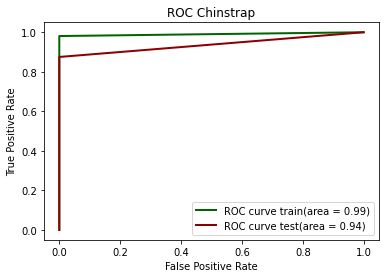

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_test = log_reg.predict(X_test_prepared)
y_pred_train = log_reg.predict(X_train_prepared)

fpr_test, tpr_test, _ = roc_curve(y_test_new,y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, _ = roc_curve(y_train_new,y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

plt.plot(fpr_train,tpr_train,color="darkgreen",lw=2,label="ROC curve train(area = %0.2f)" % roc_auc_train,)
plt.plot(fpr_test,tpr_test,color="darkred",lw=2,label="ROC curve test(area = %0.2f)" % roc_auc_test,)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Chinstrap")
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_train_new = (y_train==2)
y_train_new = y_train_new.astype(int)
print(y_train_new)
y_test_new = (y_test==2)
y_test_new = y_test_new.astype(int)

66     0
229    1
7      0
140    0
323    1
      ..
188    0
71     0
106    0
270    1
102    0
Length: 275, dtype: int64


In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_prepared, y_train_new)

LogisticRegression(max_iter=1000)

In [ ]:
score_entrenamiento = log_reg.score(X_train_prepared,y_train_new)
score = log_reg.score(X_test_prepared,y_test_new)
y_pred = log_reg.predict(X_train_prepared)
y_pred_test = log_reg.predict(X_test_prepared)
print("La precisión en el conjunto de entrenamiento es:", score_entrenamiento)
print("La precisión en el conjunto de test es:", score)
print("f1 score en el conjunto de entrenamiento es:", f1_score(y_train_new,y_pred))
print("f1 score en el conjunto de test es:", f1_score(y_test_new,y_pred_test))

La precisión en el conjunto de entrenamiento es: 0.9963636363636363
La precisión en el conjunto de test es: 1.0
f1 score en el conjunto de entrenamiento es: 0.9951219512195122
f1 score en el conjunto de test es: 1.0


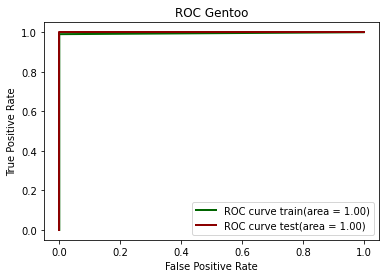

In [ ]:
y_pred_test = log_reg.predict(X_test_prepared)
y_pred_train = log_reg.predict(X_train_prepared)

fpr_test, tpr_test, _ = roc_curve(y_test_new,y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, _ = roc_curve(y_train_new,y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

plt.plot(fpr_train,tpr_train,color="darkgreen",lw=2,label="ROC curve train(area = %0.2f)" % roc_auc_train,)
plt.plot(fpr_test,tpr_test,color="darkred",lw=2,label="ROC curve test(area = %0.2f)" % roc_auc_test,)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Gentoo")
plt.legend(loc="lower right")
plt.show()

En este caso, no se clasifica cada clase con un "score" de 1

#**Sprint 2**

Se entrenan cuatro modelos de árbol de decisión, añadiendo cada vez más restricciones. El primero sin restricciones, el segundo limitando la profundidad del árbol a cuatro capas, el tercero obligando a que un nodo tenga al menos 5 instancias para poder generar subnodos, y en el cuarto obligando a que un nodo solo pueda generar subnodos si cada uno de ellos tiene al menos tres instancias.

**SE PRESENTA DIRECTAMENTE LA PARTE OPCIONAL, ES DECIR, CON LOS ATRIBUTOS CATEGÓRICOS QUE SE AÑADIERON AL PRINCIPIO**

##**1. Por defecto**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train_prepared, y_train_tree)

DecisionTreeClassifier()

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
print('La precisión del modelo en el conjunto de entrenamiento es:',tree.score(X_train_prepared, y_train_tree))
y_pred_train = tree.predict(X_train_prepared)
train_conf_matrix = confusion_matrix(y_train_tree, y_pred_train)
print('La matriz de confusión en el conjunto de etrenamiento es:\n',train_conf_matrix)
print('f1 score en el conjunto de etrenamiento:',f1_score(y_train_tree, y_pred_train, average='weighted'))

La precisión del modelo en el conjunto de entrenamiento es: 1.0
La matriz de confusión en el conjunto de etrenamiento es:
 [[120   0   0]
 [  0  52   0]
 [  0   0 103]]
f1 score en el conjunto de etrenamiento: 1.0


In [ ]:
print('La precisión del modelo en el conjunto de test es:',tree.score(X_test_prepared, y_test_tree))
y_pred_test = tree.predict(X_test_prepared)
test_conf_matrix = confusion_matrix(y_test_tree, y_pred_test)
print('La matriz de confusión en el conjunto de test es:\n',test_conf_matrix)
print('f1 score en el conjunto de test:',f1_score(y_test_tree, y_pred_test, average='weighted'))

La precisión del modelo en el conjunto de test es: 0.9855072463768116
La matriz de confusión en el conjunto de test es:
 [[31  0  1]
 [ 0 16  0]
 [ 0  0 21]]
f1 score en el conjunto de test: 0.9855607449136266


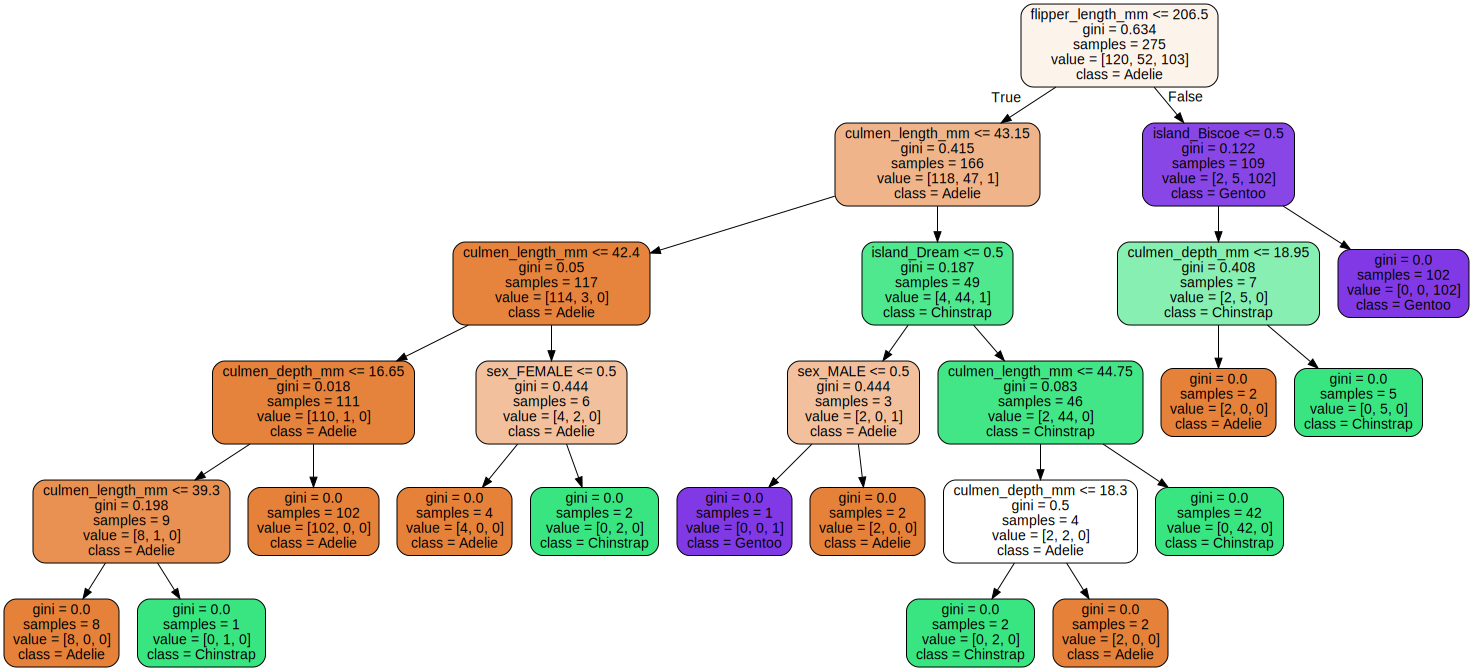

In [ ]:
from sklearn.tree import export_graphviz
from graphviz import Source

import os
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree images") #!
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
tree,
out_file=os.path.join(IMAGES_PATH,"iris_tree_01.dot"),
feature_names=list(X_train_prepared.columns),
class_names=list(y_train_tree.cat.categories),
rounded=True,
filled=True
)

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree_01.dot"))


##**2. Limitando la profundidad**

In [ ]:
tree_depth = DecisionTreeClassifier(max_depth=4)
tree_depth.fit(X_train_prepared, y_train_tree)

DecisionTreeClassifier(max_depth=4)

In [ ]:
print('La precisión del modelo en el conjunto de entrenamiento es:',tree_depth.score(X_train_prepared, y_train_tree))
y_pred_train_depth = tree_depth.predict(X_train_prepared)
train_conf_matrix_depth = confusion_matrix(y_train_tree, y_pred_train_depth)
print('La matriz de confusión en el conjunto de entrenamiento es:\n',train_conf_matrix_depth)
print('f1 score en el conjunto de entrenamiento:',f1_score(y_train_tree, y_pred_train_depth, average='weighted'))

La precisión del modelo en el conjunto de entrenamiento es: 0.9890909090909091
La matriz de confusión en el conjunto de entrenamiento es:
 [[120   0   0]
 [  3  49   0]
 [  0   0 103]]
f1 score en el conjunto de entrenamiento: 0.988996232956629


In [ ]:
print('La precisión del modelo en el conjunto de test es:',tree_depth.score(X_test_prepared, y_test_tree))
y_pred_test_depth = tree_depth.predict(X_test_prepared)
test_conf_matrix_depth = confusion_matrix(y_test_tree, y_pred_test_depth)
print('La matriz de confusión en el conjunto de test es:\n',test_conf_matrix_depth)
print('f1 score en el conjunto de test:',f1_score(y_test_tree, y_pred_test_depth, average='weighted'))

La precisión del modelo en el conjunto de test es: 0.9855072463768116
La matriz de confusión en el conjunto de test es:
 [[31  0  1]
 [ 0 16  0]
 [ 0  0 21]]
f1 score en el conjunto de test: 0.9855607449136266


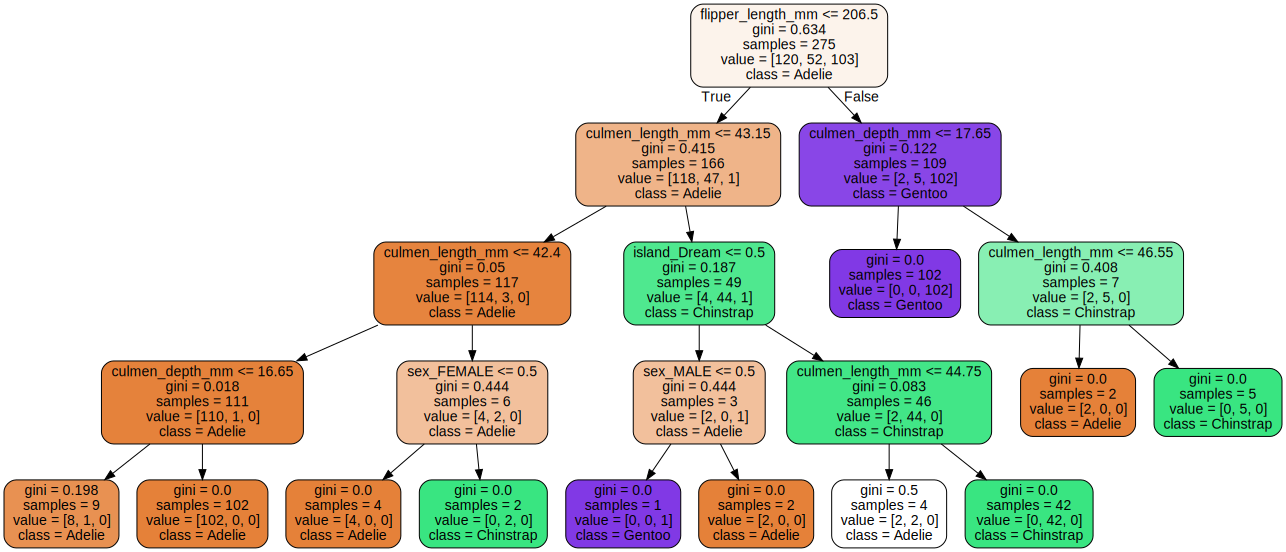

In [ ]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree images") #!
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
tree_depth,
out_file=os.path.join(IMAGES_PATH,"iris_tree_02.dot"),
feature_names=list(X_train_prepared.columns),
class_names=list(y_train_tree.cat.categories),
rounded=True,
filled=True
)

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree_02.dot"))

##**3. Limitando la ramificación**

In [ ]:
tree_split = DecisionTreeClassifier(min_samples_split=5)
tree_split.fit(X_train_prepared, y_train_tree)

DecisionTreeClassifier(min_samples_split=5)

In [ ]:
print('La precisión del modelo en el conjunto de entrenamiento es:',tree_split.score(X_train_prepared, y_train_tree))
y_pred_train_split = tree_split.predict(X_train_prepared)
train_conf_matrix_split = confusion_matrix(y_train_tree, y_pred_train_split)
print('La matriz de confusión en el conjunto de entrenamiento es:\n',train_conf_matrix_split)
print('f1 score en el conjunto de entrenamiento:',f1_score(y_train_tree, y_pred_train_split, average='weighted'))

La precisión del modelo en el conjunto de entrenamiento es: 0.9890909090909091
La matriz de confusión en el conjunto de entrenamiento es:
 [[120   0   0]
 [  2  50   0]
 [  1   0 102]]
f1 score en el conjunto de entrenamiento: 0.9890780787308764


In [ ]:
print('La precisión del modelo en el conjunto de test es:',tree_split.score(X_test_prepared, y_test_tree))
y_pred_test_split = tree_split.predict(X_test_prepared)
test_conf_matrix_split = confusion_matrix(y_test_tree, y_pred_test_split)
print('La matriz de confusión en el conjunto de test es:\n',test_conf_matrix_split)
print('f1 score en el conjunto de test:',f1_score(y_test_tree, y_pred_test_split, average='weighted'))

La precisión del modelo en el conjunto de test es: 0.9710144927536232
La matriz de confusión en el conjunto de test es:
 [[32  0  0]
 [ 1 15  0]
 [ 1  0 20]]
f1 score en el conjunto de test: 0.9710431721173006


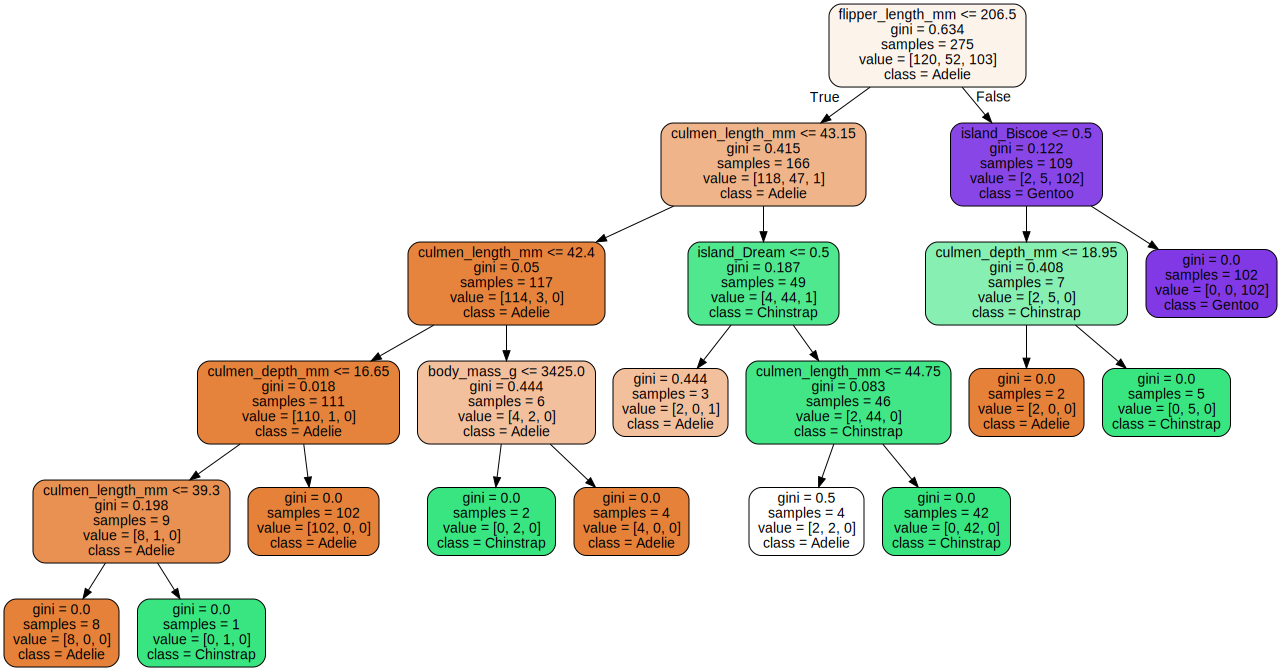

In [ ]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree images") #!
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
tree_split,
out_file=os.path.join(IMAGES_PATH,"iris_tree_03.dot"),
feature_names=list(X_train_prepared.columns),
class_names=list(y_train_tree.cat.categories),
rounded=True,
filled=True
)

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree_03.dot"))

##**4. Limitando más la ramificación**

In [ ]:
tree_leaf = DecisionTreeClassifier(min_samples_leaf=3)
tree_leaf.fit(X_train_prepared, y_train_tree)

DecisionTreeClassifier(min_samples_leaf=3)

In [ ]:
print('La precisión del modelo en el conjunto de entrenamiento es:',tree_leaf.score(X_train_prepared, y_train_tree))
y_pred_train_leaf = tree_leaf.predict(X_train_prepared)
train_conf_matrix_leaf = confusion_matrix(y_train_tree, y_pred_train_leaf)
print('La matriz de confusión en el conjunto de entrenamiento es:\n',train_conf_matrix_leaf)
print('f1 score en el conjunto de entrenamiento:',f1_score(y_train_tree, y_pred_train_leaf, average='weighted'))

La precisión del modelo en el conjunto de entrenamiento es: 0.9781818181818182
La matriz de confusión en el conjunto de entrenamiento es:
 [[119   1   0]
 [  4  48   0]
 [  1   0 102]]
f1 score en el conjunto de entrenamiento: 0.9780817595554039


In [ ]:
print('La precisión del modelo en el conjunto de test es:',tree_leaf.score(X_test_prepared, y_test_tree))
y_pred_test_leaf = tree_leaf.predict(X_test_prepared)
test_conf_matrix_leaf = confusion_matrix(y_test_tree, y_pred_test_leaf)
print('La matriz de confusión en el conjunto de test es:\n',test_conf_matrix_leaf)
print('f1 score en el conjunto de test:',f1_score(y_test_tree, y_pred_test_leaf, average='weighted'))

La precisión del modelo en el conjunto de test es: 0.9855072463768116
La matriz de confusión en el conjunto de test es:
 [[32  0  0]
 [ 0 16  0]
 [ 1  0 20]]
f1 score en el conjunto de test: 0.9854419881991462


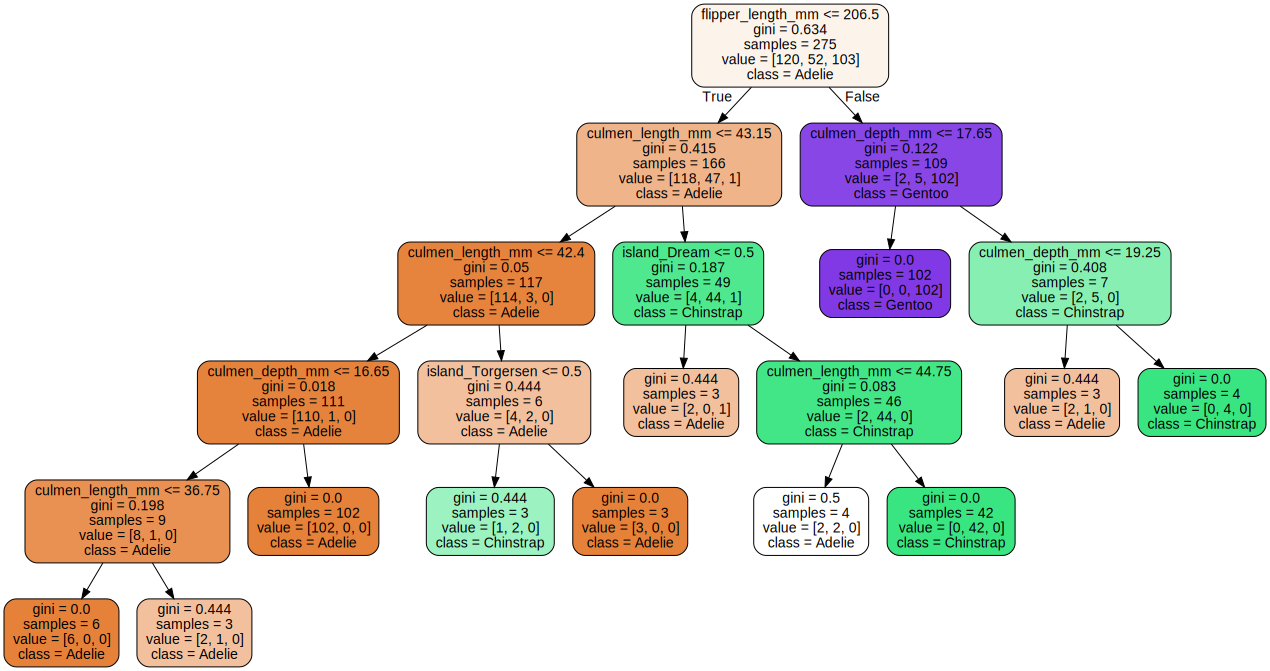

In [ ]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree images") #!
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
tree_leaf,
out_file=os.path.join(IMAGES_PATH,"iris_tree_04.dot"),
feature_names=list(X_train_prepared.columns),
class_names=list(y_train_tree.cat.categories),
rounded=True,
filled=True
)

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree_04.dot"))

##**5. Comparativa de modelos**

La comparativa entre los árboles de decisión:

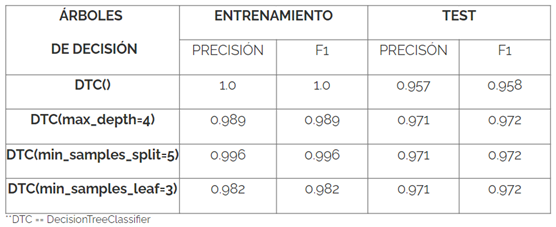

La comparativa con los modelos empleados en el sprint 1:

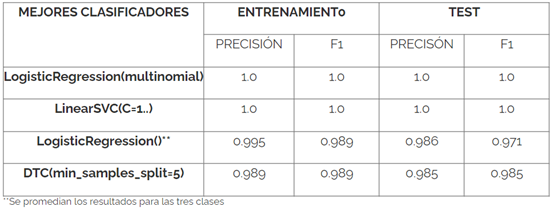

Los mejores resultados se tienen para la regresión softmax y el clasificador de vectores de soporte lineal. Es decir, se tienen una clases que son linealmente o "cuasi" linealmente separables, por lo que los modelos que suponen esta estructura en los datos tienen un gran desempeño. El árbol de decisión no presupone ningún tipo de estructura, lo que hace más difícil la predicción en estos casos.

#**Sprint 3**

**ENTRENAMIENTO Y EVALUACIÓN DE DOS TIPOS DE ENSEMBLES BAJO DIFERENTES CONFIGURACIONES DE HIPERPARÁMETROS**

Recalco que para cada uno de los modelos se preparó un bucle de 100 iteraciones, para entrenarlos y evaluar su score 100 veces, dando como resultado final la media de estas 100 puntuaciones. Se hizo esto puesto que los resultados del modelo presentan cierta variación para cada entrenamiento. 

##**Entrenando y evaluando un BaggingClassifier**

Como algoritmo base para el ensemble se emplea un DecisionTreeClassifier con min_samples_split=5 como único parámetro regularizador. Se entrenan cuatro ensembles variando ligeramente sus hiperparámetros, y se presenta el score, y el tiempo que tardan en entrenarse 100 veces. 

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import time 
bag_clf = BaggingClassifier(DecisionTreeClassifier(min_samples_split=5))
bag_score = []
bag_score_train = []
time0 = time.time()
for i in range(100):
  bag_clf.fit(X_train_prepared,y_train_tree)
  bag_score.append(bag_clf.score(X_test_prepared,y_test_tree))
  bag_score_train.append(bag_clf.score(X_train_prepared,y_train_tree))
time1 = time.time()
print("La precisión del ensemble en el conjunto de test:", np.mean(bag_score))
print("La precisión del ensemble en el conjunto de train:", np.mean(bag_score_train))
print("El tiempo de ejecución:", time1-time0)

La precisión del ensemble en el conjunto de test: 0.9805797101449278
La precisión del ensemble en el conjunto de train: 0.9934909090909091
El tiempo de ejecución: 5.620558500289917


"Sampleando" las instancias del conjunto de entrenamiento y aumentando el número de estimadores:

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(min_samples_split=5),n_estimators=200, max_samples=250, bootstrap=True, n_jobs=-1)
bag_score = []
bag_score_train = []
##!!Analizar también el tiempo de ejecución!!
time0 = time.time()
for i in range(100):
  bag_clf.fit(X_train_prepared, y_train_tree)
  bag_score.append(bag_clf.score(X_test_prepared,y_test_tree))
  bag_score_train.append(bag_clf.score(X_train_prepared,y_train_tree))
time1 = time.time()
print("La precisión del ensemble en el conjunto de test:", np.mean(bag_score))
print("La precisión del ensemble en el conjunto de test:", np.mean(bag_score_train))
print("El tiempo de ejecución:", time1-time0)

La precisión del ensemble en el conjunto de test: 0.99768115942029
La precisión del ensemble en el conjunto de test: 0.9986545454545456
El tiempo de ejecución: 96.64862179756165


El considerable aumento del número de estimadores empleados en el ensemble se traduce en una mejora significativa del desempeño del modelo, así como en el tiempo de ejecución.

"Sampleando" las características del conjunto de datos:

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(min_samples_split=5),n_estimators=200, max_samples=250, bootstrap=True, n_jobs=-1, max_features=0.5)
bag_score = []
time0 = time.time()
for i in range(100):
  bag_clf.fit(X_train_prepared, y_train)
  bag_score.append(bag_clf.score(X_test_prepared,y_test))
time1 = time.time() 
print("La precisión del ensemble en el conjunto de test:", np.mean(bag_score))
print("El tiempo de ejecución:", time1-time0)

La precisión del ensemble en el conjunto de test: 0.9991304347826088
El tiempo de ejecución: 46.54896664619446


Sorprendentemente, reduciendo el número de características empleadas en cada estimador se obtiene un resultado final incluso mejor que en el caso anterior.

Aumento importante del número de estimadores:

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(min_samples_split=5),n_estimators=500, max_samples=250, bootstrap=True, n_jobs=-1)
bag_score = []
time0 = time.time()
for i in range(100):
  bag_clf.fit(X_train_prepared, y_train)
  bag_score.append(bag_clf.score(X_test_prepared,y_test))
time1 = time.time()
print("La precisión del ensemble en el conjunto de test:", np.mean(bag_score))
print("El tiempo de ejecución:", time1-time0)

La precisión del ensemble en el conjunto de test: 0.9995652173913043
El tiempo de ejecución: 116.05638885498047


Aumentar el número de estimadores no logra un score de 1, y aumenta el tiempo de ejecución como cabría esperar.

##**Entrenando y evaluando un Adaboost Classifier**

El desempeño de este ensemble es mucho mejor que el del anterior, obteniéndose una precisión de 1 con tan sólo 10 estimadores.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=5), n_estimators=10, learning_rate=0.5)
ada_score = []
time0 = time.time()
for i in range(100):
  ada_clf.fit(X_train_prepared,y_train)
  ada_score.append(ada_clf.score(X_test_prepared,y_test))
time1 = time.time()
print("La precisión del ensemble en el conjunto de test:", np.mean(bag_score))
print("El tiempo de ejecución:", time1-time0)

La precisión del ensemble en el conjunto de test: 0.9995652173913043
El tiempo de ejecución: 0.866804838180542


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=5), n_estimators=100, learning_rate=1)
ada_score = []
ada_score_train = []
time0 = time.time()
for i in range(100):
  ada_clf.fit(X_train_prepared,y_train_tree)
  ada_score.append(ada_clf.score(X_test_prepared,y_test_tree))
  ada_score_train.append(ada_clf.score(X_train_prepared,y_train_tree))
time1 = time.time()
print("La precisión del ensemble en el conjunto de test:", np.mean(bag_score))
print("La precisión del ensemble en el conjunto de train:", np.mean(bag_score_train))
print("El tiempo de ejecución:", time1-time0)

La precisión del ensemble en el conjunto de test: 0.99768115942029
La precisión del ensemble en el conjunto de train: 0.9986545454545456
El tiempo de ejecución: 1.2330124378204346


Este ensemble es mucho más rápido que el otro. El aumento de estimadores apenas se refleja en el tiempo de ejecución.
AdaBoostClassifier es claramente superior a BaggingClassifier para este dataset.

##**Parte Opcional: Exploración de las clases BaggingRegressor y RandomForestRegressor**

###**Importación y tratamiento inicial de los datos de las startups**

In [ ]:
! kaggle datasets download farhanmd29/50-startups
! unzip 50-startups.zip

  0% 0.00/1.30k [00:00<?, ?B/s]
100% 1.30k/1.30k [00:00<00:00, 2.18MB/s]
Archive:  50-startups.zip
  inflating: 50_Startups.csv         


In [ ]:
import pandas as pd

df = pd.read_csv('50_Startups.csv')
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [ ]:
df_num = df.drop('State', axis=1) # Eliminar variable categórica
df_num.head()

X = df_num.drop('Profit',axis=1)
y = df_num['Profit']

# Particionado en entrenamiento + test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

###**Elección del mejor TreeRegressor**

Antes de entrenar y evaluar el BaggingRegressor y el RandomForestRegressor, se emplea GridSearchCV para buscar la mejor combinación de max:depth, min_samples_split y min_samples_leaf, teniendo: DecisionTreeRegressor(max_depth=5, min_samples_split=4, min_samples_leaf=2).

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
parameters = {'max_depth':[1,2,3,4,5,6], 'min_samples_split':[2,4,6,8,10], 'min_samples_leaf':[1,2,3,4,5]}
tree = DecisionTreeRegressor()
tree_reg = GridSearchCV(tree, parameters,scoring='neg_root_mean_squared_error')
tree_reg.fit(X_train, y_train)
resultados = pd.DataFrame(tree_reg.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_score,std_test_score
106,5,2,4,-9933.294695,3360.707591
131,6,2,4,-10511.912919,4819.116512
130,6,2,2,-10615.660265,4872.845628
105,5,2,2,-10665.557761,4269.355121
137,6,3,6,-10711.389346,5339.913929
80,4,2,2,-10903.099958,3305.051594
101,5,1,4,-10983.183345,3102.510673
82,4,2,6,-11425.437794,5394.657094
135,6,3,2,-11473.746777,5505.191460
112,5,3,6,-11473.746777,5505.191460


In [ ]:
tree_reg.best_estimator_

DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=4)

###**Entrenamiento y evaluación de un BaggingRegressor**

El RMSE en los ejemplos de clase con los otros dos algoritmos rondaba 10000, utilizando árboles de decisión con una profundidad máxima únicamente de 2, en ensembles con 100 estimadores. Se mejoran los resultados aumentando el número de estimadores y modificando los hiperparámetros del árbol de decisión como se ha comentado.



> Hiperparámetros por defecto



In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

bag_reg = BaggingRegressor(n_estimators=500)
RMSE = []
for i in range(100):
  bag_reg.fit(X_train, y_train)
  y_pred = bag_reg.predict(X_test)
  RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
print('RMSE=', np.mean(RMSE)) 

RMSE= 9087.905278304504




> Hiperparámetros buscados



In [ ]:
bag_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=4), n_estimators=500)
RMSE = []
for i in range(100):
  bag_reg.fit(X_train, y_train)
  y_pred = bag_reg.predict(X_test)
  RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
print('RMSE=', np.mean(RMSE)) 

RMSE= 8929.451755000442


###**Entrenamiento y evaluación de un RandomForestRegressor**



> Hiperparámetros por defecto



In [ ]:
from sklearn.ensemble import RandomForestRegressor
for_reg = RandomForestRegressor(n_estimators=500)
RMSE = []
for i in range(100):
  for_reg.fit(X_train, y_train)
  y_pred = for_reg.predict(X_test)
  RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
print('RMSE=', np.mean(RMSE)) 

RMSE= 9079.615784223879




> Hiperparámetros buscados



In [ ]:
for_reg = RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=4,n_estimators=500)
RMSE = []
for i in range(100):
  for_reg.fit(X_train, y_train)
  y_pred = for_reg.predict(X_test)
  RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
print('RMSE=', np.mean(RMSE)) 

RMSE= 8923.60228400156


#**Parte Opcional**

Multitud de modelos han dado un resultado óptimo en la clasificación de pingüinos, pero podemos quedarnos con el AdaBoostClassifier por su velocidad y precisión, que hemos empleado con un DecisionTreeClassifier como algoritmo de base. Por tanto, se emplea GridSearchCV para buscar la mejor configuración de hiperparámetros para un árbol de decisión.

In [ ]:
parameters = {'max_depth':[1,2,3,4,5,6], 'min_samples_split':[2,4,6,8,10], 'min_samples_leaf':[1,2,3,4,5]}
tree = DecisionTreeClassifier()
tree_clf = GridSearchCV(tree, parameters)
tree_clf.fit(X_train_prepared, y_train_tree)
resultados = pd.DataFrame(tree_clf.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_score,std_test_score
81,4,2,4,0.967273,0.017814
100,5,1,2,0.967273,0.021203
75,4,1,2,0.963636,0.016262
50,3,1,2,0.963636,0.011499
82,4,2,6,0.963636,0.016262
85,4,3,2,0.963636,0.016262
87,4,3,6,0.963636,0.016262
91,4,4,4,0.963636,0.019917
95,4,5,2,0.963636,0.019917
99,4,5,10,0.963636,0.019917


In [ ]:
tree_clf.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=4)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=4), n_estimators=100, learning_rate=1)
ada_score = []
time0 = time.time()
for i in range(100):
  ada_clf.fit(X_train_prepared,y_train_tree)
  ada_score.append(ada_clf.score(X_test_prepared,y_test_tree))
time1 = time.time()
print("La precisión del ensemble en el conjunto de test:", np.mean(bag_score))
print("El tiempo de ejecución:", time1-time0)

La precisión del ensemble en el conjunto de test: 0.9995652173913043
El tiempo de ejecución: 4.199790000915527


Se produce un aumento en el tiempo de ejecución.